In [15]:
from numpy import zeros,array,sqrt,exp,copy,arange,mean,roll,std,flip
from numpy import random as nprandom
from random import random,randrange
from pylab import figure,plot,show,xlim,ylim,title,legend,xlabel,ylabel,savefig,grid

In [1]:
# compute energy of tertiary structure of protein
def calc_energy(monomer_coords,monomer_array):
    energy=0.0

    # compute energy due to all adjacencies (including directly bonded monomers)
    for i in range(N):
        for neighbour in [[-1,0],[1,0],[0,-1],[0,1]]: # the four neighbour directions
            neighbour_monomer=monomer_array[monomer_coords[i,0]+neighbour[0],monomer_coords[i,1]+neighbour[1]]
            
            if neighbour_monomer==1: # check neighbour is not empty
                energy+=eps
       
    # divide by 2 to correct for double-counting
    energy=energy/2.0
    
    # correct energy to not count directly bonded monomer neighbours
    energy-=(N-1)*eps
        
    return energy

def dist(position1,position2):
    return sqrt((position1[0]-position2[0])**2+(position1[1]-position2[1])**2)

eps=-5.0 # interaction energy
N=30 # length of protein
T=0.5 # temperature for Monte Carlo
n=10000000 # number of Monte Carlo steps

# T_f=0.5
# T_steps=4
# T_i=T_f+T_steps-1
# T_array= zeros(n)
# for step in range(T_steps):
#     T_array[int(step*n/T_steps):int((step+1)*n/T_steps)]=(T_i-T_f)*(1-float(step)/(T_steps-1))+T_f

T_f=0.5
T_steps=20
T_i=10
T_array= zeros(n)
for step in range(T_steps):
    T_array[int(step*n/T_steps):int((step+1)*n/T_steps)]=(T_i-T_f)*(1-float(step)/(T_steps-1))+T_f

energy_array=zeros(n) # initialize array to hold energy

# initialize arrays to store protein information

# first column is x coordinates, second column is y coordinates, of all N monomers
monomer_coords=zeros((N,2),dtype='int')

# initialize position of polymer as straight horizontal line in middle of domain
monomer_coords[:,0]=range(N//2,3*N//2)
monomer_coords[:,1]=N

# 2D array representing lattice, equal to 0 when a lattice point is empty, and equal to 1 when there is a monomer at the lattice point
monomer_array=zeros((2*N+1,2*N+1),dtype='int')

# fill lattice array
for i in range(N):
    monomer_array[monomer_coords[i,0],monomer_coords[i,1]]=1

# calculate energy of initial protein structure
energy=calc_energy(monomer_coords,monomer_array)

# do Monte Carlo procedure to find optimal protein structure
for j in range(n):        
    energy_array[j]=energy
    
    # move protein back to centre of array
    shift_x=int(mean(monomer_coords[:,0])-N)
    shift_y=int(mean(monomer_coords[:,1])-N)
    monomer_coords[:,0]-=shift_x
    monomer_coords[:,1]-=shift_y
    monomer_array=roll(monomer_array,-shift_x,axis=0)
    monomer_array=roll(monomer_array,-shift_y,axis=1)
    
    # pick random monomer
    i=randrange(N)
    cur_monomer_pos=monomer_coords[i,:]
    
    # pick random diagonal neighbour for monomer
    direction=randrange(4)
    
    if direction==0:
        neighbour=array([-1,-1]) # left/down
    elif direction==1:
        neighbour=array([-1,1]) # left/up
    elif direction==2:
        neighbour=array([1,1]) # right/up
    elif direction==3:
        neighbour=array([1,-1]) # right/down
    
    new_monomer_pos=cur_monomer_pos+neighbour
    
    # check if neighbour lattice point is empty
    if monomer_array[new_monomer_pos[0],new_monomer_pos[1]]==0:
        # check if it is possible to move monomer to new position without stretching chain
        distance_okay=False
        if i==0:
            if dist(new_monomer_pos,monomer_coords[i+1,:])<1.1:
                distance_okay=True
        elif i==N-1:
            if dist(new_monomer_pos,monomer_coords[i-1,:])<1.1:
                distance_okay=True
        else:
            if dist(new_monomer_pos,monomer_coords[i-1,:])<1.1 and dist(new_monomer_pos,monomer_coords[i+1,:])<1.1:
                distance_okay=True
                
        if distance_okay:
            # calculate new energy
            new_monomer_coords=copy(monomer_coords)
            new_monomer_coords[i,:]=new_monomer_pos
            
            new_monomer_array=copy(monomer_array)
            new_monomer_array[cur_monomer_pos[0],cur_monomer_pos[1]]=0
            new_monomer_array[new_monomer_pos[0],new_monomer_pos[1]]=1
            
            new_energy=calc_energy(new_monomer_coords,new_monomer_array)
            
            if random()<exp(-(new_energy-energy)/T_array[j]):
                # make switch
                energy=new_energy
                monomer_coords=copy(new_monomer_coords)
                monomer_array=copy(new_monomer_array)

Energy averaged over last half of simulations is: -81.34
Energy averaged over last quarter of simulations is: -89.37


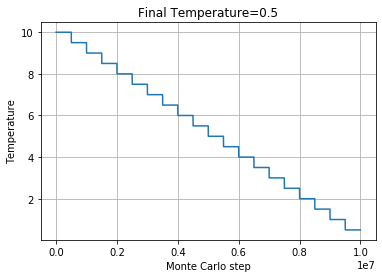

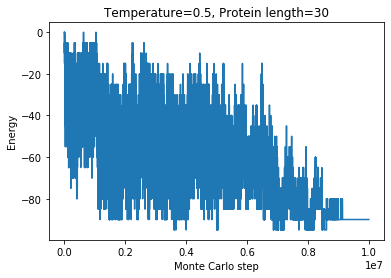

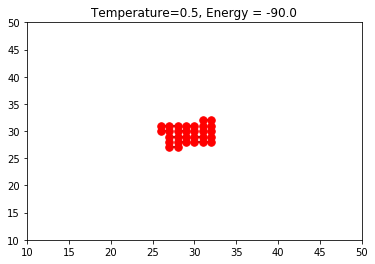

In [24]:
figure()
title("Final Temperature={}".format(T_array[-1]))
plot(T_array)
xlabel('Monte Carlo step')
ylabel('Temperature')
grid()
savefig('Temperature.png')

T = T_array[-1]
figure()
title('Temperature=%.1f, Protein length=%d'%(T,N))
plot(energy_array)
xlabel('Monte Carlo step')
ylabel('Energy')
savefig('energy_vs_step_T%d_N%d_n%d.png'%(10*T,N,n))

figure()
plot(monomer_coords[:,0],monomer_coords[:,1],'-k') # plot bonds
title('Temperature=%.1f, Energy = %.1f'%(T,energy))
# plot monomers
for i in range(N):
    plot(monomer_coords[i,0],monomer_coords[i,1],'.r',markersize=15)  
xlim([N/3.0,5.0*N/3.0])
ylim([N/3.0,5.0*N/3.0])
savefig('final_protein_T%d_N%d_n%d.png'%(10*T,N,n))

print ('Energy averaged over last half of simulations is: %.2f'%mean(energy_array[int(n/2):]))
print ('Energy averaged over last quarter of simulations is: %.2f'%mean(energy_array[-int(n/4):]))

show()

In [9]:
mean_results = []
for t in range(19):
    mean_results.append(mean(energy_array[t*int(n/T_steps):(t+1)*int(n/T_steps)]))
mean_results.append(mean(energy_array[-1*int(n/T_steps):]))

In [10]:
std_results = []
for t in range(19):
    std_results.append(std(energy_array[t*int(n/T_steps):(t+1)*int(n/T_steps)]))
std_results.append(std(energy_array[-1*int(n/T_steps):]))

In [18]:
temperature_results = flip(arange(0.5,10.5,0.5))

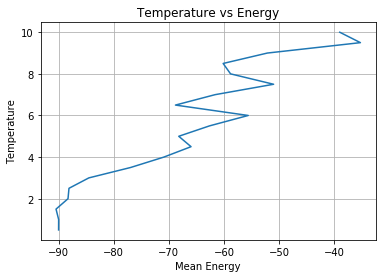

In [25]:
figure()
title("Temperature vs Energy")
plot(mean_results, temperature_results)
xlabel('Mean Energy')
ylabel('Temperature')
grid()
savefig('tempvsenergy.png')

In [22]:
mean_results

[-38.98408,
 -35.24236,
 -52.12534,
 -60.14649,
 -58.80047,
 -50.99013,
 -61.60642,
 -68.79764,
 -55.59727,
 -62.61837,
 -68.20258,
 -65.9682,
 -70.89769,
 -76.93278,
 -84.51499,
 -88.11484,
 -88.29111,
 -90.46209,
 -89.9895,
 -90.0]